## Setup

In [4]:
!pip -q install numpy pillow matplotlib tqdm albumentations wandb

In [ ]:
# !pip install -q albumentations

In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=e00ff15c875f0af7e3093897c8fbb97918313b60df499b95f8c15df3b7662a7a
  Stored in directory: /home/oaz/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## ADE20K

In [3]:
import os
import wget
import tarfile

url = "http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip"

output_dir = './ADE20K'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

file_path = os.path.join(output_dir, 'ADEChallengeData2016.zip')
wget.download(url, file_path)

import zipfile
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

## Libraries

In [1]:
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
# import cv2
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import scipy.ndimage.morphology as morph
import datetime
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from BEIT import BEiT3
import time
import wandb

In [2]:
wandb.init(entity='2024CCP', project='yumin', name='base_ADE20K')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yung-ym-lee (2024CCP). Use `wandb login --relogin` to force relogin


In [3]:
RANDOM_SEED = 42

def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.backends.cudnn.benchmark = False

set_seed()

## Visualization

In [4]:
label_path = './ADE20K/ADEChallengeData2016/objectInfo150.txt'
labels = []
val_labels = []
with open(label_path, 'r') as file:
    for line in file:
        labels.append(line.split("\t")[-1].strip())
        val_labels.append(line.split("\t")[-1].strip())
labels[0] = 'background'
del val_labels[0]

def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

def color_map_viz():
    nclasses = len(labels) - 1
    row_size = 150
    col_size = 300
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    plt.imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()

# color_map_viz()

ADE_train_00000032


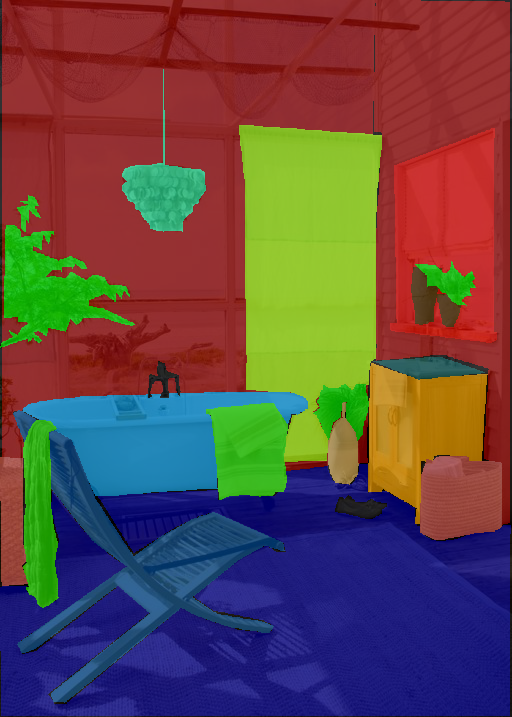

In [5]:
root = './ADE20K/ADEChallengeData2016/'

img_path = root + 'images/training/'
mask_path = root + 'annotations/training/'

img_list = os.listdir(mask_path)
train_set = [os.path.splitext(file)[0] for file in img_list]
train_set.sort()


img_idx = 31

img = Image.open(img_path + train_set[img_idx] + '.jpg')
mask = np.array(Image.open(mask_path + train_set[img_idx] + '.png'))[:, :, np.newaxis]
cmap = color_map()[:, np.newaxis, :]

new_im = np.dot(mask == 0, cmap[0])
for i in range(1, cmap.shape[0]):
    new_im += np.dot(mask == i, cmap[i])
new_im = Image.fromarray(new_im.astype(np.uint8))
blend_image = Image.blend(img, new_im, alpha=0.8)
print(train_set[img_idx])
blend_image

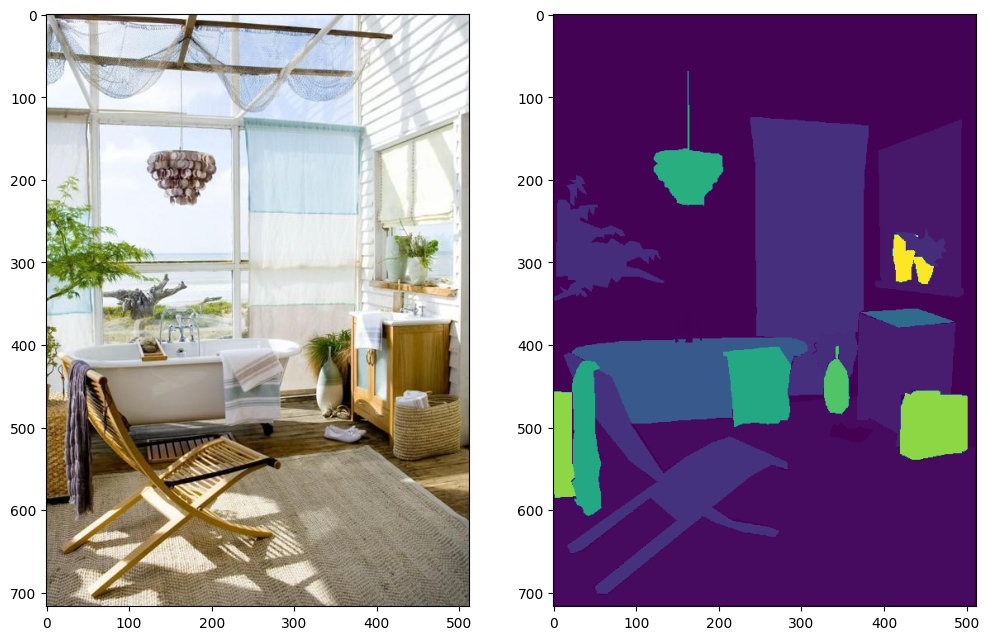

In [6]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

## Dataset

In [7]:
img_transforms = A.Compose([
    A.Resize(height=224, width=224, interpolation=1, always_apply=True),
    ToTensorV2()
])

mask_transforms = A.Compose([
    A.Resize(height=224, width=224, interpolation=0, always_apply=True),
])

In [8]:
class ADE20KDataset(Dataset):
    def __init__(self, root, image_set='train', img_transforms=img_transforms, mask_transforms=mask_transforms):
        self.root = root
        self.image_set = image_set
        self.img_transforms = img_transforms
        self.mask_transforms=mask_transforms

        self.images_dir = os.path.join(root, 'images', image_set)
        self.labels_dir = os.path.join(root, 'annotations', image_set)

        # all data
        self.images = sorted(os.listdir(self.images_dir))
        self.labels = sorted(os.listdir(self.labels_dir))

        # sample images
        # sample_num = 500
        # indices = list(range(len(self.images)))
        # selected_indices = random.sample(indices, sample_num)
        # self.images = [self.images[i] for i in selected_indices]
        # self.labels = [self.labels[i] for i in selected_indices]

        self.num_classes = 150  # ADE20K 클래스 수

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.images[index])
        label_path = os.path.join(self.labels_dir, self.labels[index])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(label_path)

        img = np.array(img).astype(np.float32)
        mask = np.array(mask)

        # 클래스별 마스크 생성
        multi_mask = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)

        for c in range(1, self.num_classes+1):
            multi_mask[:, :, c - 1] = (mask == c)

        if self.img_transforms:
            img = img_transforms(image=img)['image']

        if self.mask_transforms:
            multi_mask= mask_transforms(image=multi_mask)['image']
            multi_mask = torch.from_numpy(multi_mask).permute(2,0,1)

        return img, multi_mask

In [9]:
train_dataset = ADE20KDataset(root='./ADE20K/ADEChallengeData2016', image_set='training', img_transforms=img_transforms, mask_transforms=mask_transforms)
valid_dataset = ADE20KDataset(root='./ADE20K/ADEChallengeData2016', image_set='validation', img_transforms=img_transforms, mask_transforms=mask_transforms)

## Dataloader

In [10]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

## Train

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)

    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [12]:
SAVED_DIR = './'

def save_model(model, file_name='best_model.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [13]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.cuda()
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = 150#len(labels)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()

            outputs = model(images)

            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)

            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")

            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1

            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()

            dice = dice_coef(outputs, masks)
            dices.append(dice)

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(val_labels, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()

    return avg_dice

In [14]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    model.cuda()

    n_class = 150# len(val_labels)
    best_dice = 0.

    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):
            # gpu 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()

            # inference
            outputs = model(images)

            # loss 계산
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
                wandb.log({'Train Loss': round(loss.item(),4),
                           'epoch' : epoch+1,
                        #    'learning rate' : optimizer.param_groups[0]['lr']})
                           'learning rate' : scheduler.optimizer.param_groups[0]["lr"]})

        scheduler.step()
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            wandb.log({'Validation Dice': dice})

            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

In [15]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=1024, num_classes=150 ):
        super(ASPP, self).__init__()
        # atrous 3x3, rate=6
        self.conv_3x3_r6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        # atrous 3x3, rate=12
        self.conv_3x3_r12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        # atrous 3x3, rate=18
        self.conv_3x3_r18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        # atrous 3x3, rate=24
        self.conv_3x3_r24 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=24, dilation=24)
        self.drop_conv_3x3 = nn.Dropout2d(0.5)

        self.conv_1x1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.drop_conv_1x1 = nn.Dropout2d(0.5)

        self.conv_1x1_out = nn.Conv2d(out_channels, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # 1번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        # print("feature_map = ",feature_map.shape)
        out_3x3_r6 = self.drop_conv_3x3(F.relu(self.conv_3x3_r6(feature_map)))
        out_img_r6 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r6)))
        out_img_r6 = self.conv_1x1_out(out_img_r6)
        # 2번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r12 = self.drop_conv_3x3(F.relu(self.conv_3x3_r12(feature_map)))
        out_img_r12 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r12)))
        out_img_r12 = self.conv_1x1_out(out_img_r12)
        # 3번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r18 = self.drop_conv_3x3(F.relu(self.conv_3x3_r18(feature_map)))
        out_img_r18 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r18)))
        out_img_r18 = self.conv_1x1_out(out_img_r18)
        # 4번 branch
        # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
        out_3x3_r24 = self.drop_conv_3x3(F.relu(self.conv_3x3_r24(feature_map)))
        out_img_r24 = self.drop_conv_1x1(F.relu(self.conv_1x1(out_3x3_r24)))
        out_img_r24 = self.conv_1x1_out(out_img_r24)

        out = sum([out_img_r6, out_img_r12, out_img_r18, out_img_r24])

        return out

class DeepLabV2(nn.Module):
    ## VGG 위에 ASPP 쌓기
    def __init__(self, backbone, classifier, upsampling=8):
        super(DeepLabV2, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.upsampling = upsampling

    def forward(self, x):
        x = self.backbone(x)
        _, _, feature_map_h, feature_map_w = x.size()
        x = self.classifier(x)
        out = F.interpolate(x, size=(feature_map_h * self.upsampling, feature_map_w * self.upsampling), mode="bilinear")
        return out

In [16]:
backbone = BEiT3()
aspp_module = ASPP(in_channels=512, out_channels=256, num_classes=150)
model = DeepLabV2(backbone=backbone, classifier=aspp_module)

In [17]:
LR = 1e-4
NUM_EPOCHS = 10
VAL_EVERY = 1

In [18]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=1e-6)

T_max = 1
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f'Total number of parameters: {num_params}')

Total number of parameters: 105214358


In [20]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2024-08-22 17:57:09 | Epoch [1/10], Step [25/2526], Loss: 0.2624
2024-08-22 17:58:17 | Epoch [1/10], Step [50/2526], Loss: 0.0924
2024-08-22 17:59:22 | Epoch [1/10], Step [75/2526], Loss: 0.0645
2024-08-22 18:00:27 | Epoch [1/10], Step [100/2526], Loss: 0.0524
2024-08-22 18:01:30 | Epoch [1/10], Step [125/2526], Loss: 0.0443
2024-08-22 18:02:31 | Epoch [1/10], Step [150/2526], Loss: 0.0437
2024-08-22 18:03:35 | Epoch [1/10], Step [175/2526], Loss: 0.0401
2024-08-22 18:04:40 | Epoch [1/10], Step [200/2526], Loss: 0.041
2024-08-22 18:05:38 | Epoch [1/10], Step [225/2526], Loss: 0.0323
2024-08-22 18:06:42 | Epoch [1/10], Step [250/2526], Loss: 0.0389
2024-08-22 18:07:46 | Epoch [1/10], Step [275/2526], Loss: 0.043
2024-08-22 18:08:48 | Epoch [1/10], Step [300/2526], Loss: 0.0369
2024-08-22 18:09:50 | Epoch [1/10], Step [325/2526], Loss: 0.0357
2024-08-22 18:10:51 | Epoch [1/10], Step [350/2526], Loss: 0.0342
2024-08-22 18:11:54 | Epoch [1/10], Step [375/2526], Loss: 0.034

100%|██████████| 500/500 [12:50<00:00,  1.54s/it]


wall        : 0.4638
building, edifice: 0.6404
sky         : 0.8172
floor, flooring: 0.5359
tree        : 0.6770
ceiling     : 0.5521
road, route : 0.7025
bed         : 0.9055
windowpane, window: 0.7676
grass       : 0.8676
cabinet     : 0.8550
sidewalk, pavement: 0.8346
person, individual, someone, somebody, mortal, soul: 0.7340
earth, ground: 0.9050
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.9195
plant, flora, plant life: 0.7770
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.8455
water       : 0.9625
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9629
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9775
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:51<00:00,  1.54s/it]


wall        : 0.5400
building, edifice: 0.6805
sky         : 0.8062
floor, flooring: 0.6020
tree        : 0.6740
ceiling     : 0.5978
road, route : 0.7441
bed         : 0.9045
windowpane, window: 0.7576
grass       : 0.8500
cabinet     : 0.8550
sidewalk, pavement: 0.8245
person, individual, someone, somebody, mortal, soul: 0.7340
earth, ground: 0.9050
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.9087
plant, flora, plant life: 0.7750
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.8455
water       : 0.9625
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9513
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9680
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:49<00:00,  1.54s/it]


wall        : 0.5095
building, edifice: 0.6944
sky         : 0.8283
floor, flooring: 0.4991
tree        : 0.7001
ceiling     : 0.4532
road, route : 0.7346
bed         : 0.8488
windowpane, window: 0.6234
grass       : 0.8382
cabinet     : 0.8550
sidewalk, pavement: 0.7794
person, individual, someone, somebody, mortal, soul: 0.7340
earth, ground: 0.9025
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8781
plant, flora, plant life: 0.7125
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8345
car, auto, automobile, machine, motorcar: 0.8251
water       : 0.9625
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9590
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.8909
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:49<00:00,  1.54s/it]


wall        : 0.5688
building, edifice: 0.6971
sky         : 0.8072
floor, flooring: 0.6144
tree        : 0.6819
ceiling     : 0.5881
road, route : 0.7373
bed         : 0.8368
windowpane, window: 0.6415
grass       : 0.8367
cabinet     : 0.8550
sidewalk, pavement: 0.7881
person, individual, someone, somebody, mortal, soul: 0.7340
earth, ground: 0.8926
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8625
plant, flora, plant life: 0.7095
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8350
car, auto, automobile, machine, motorcar: 0.7860
water       : 0.9625
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9421
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9334
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:51<00:00,  1.54s/it]


wall        : 0.5229
building, edifice: 0.6805
sky         : 0.8174
floor, flooring: 0.5910
tree        : 0.6777
ceiling     : 0.6115
road, route : 0.7331
bed         : 0.8411
windowpane, window: 0.6984
grass       : 0.8473
cabinet     : 0.8550
sidewalk, pavement: 0.8230
person, individual, someone, somebody, mortal, soul: 0.7310
earth, ground: 0.8060
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8409
plant, flora, plant life: 0.7653
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.8224
water       : 0.9595
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.8985
mirror      : 0.9385
rug, carpet, carpeting: 0.9380
field       : 0.9405
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:48<00:00,  1.54s/it]


wall        : 0.5671
building, edifice: 0.6982
sky         : 0.8294
floor, flooring: 0.6244
tree        : 0.6952
ceiling     : 0.6266
road, route : 0.7604
bed         : 0.8480
windowpane, window: 0.6496
grass       : 0.8424
cabinet     : 0.8540
sidewalk, pavement: 0.8014
person, individual, someone, somebody, mortal, soul: 0.7330
earth, ground: 0.8356
door, double door: 0.8390
table       : 0.7930
mountain, mount: 0.8704
plant, flora, plant life: 0.7172
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8395
car, auto, automobile, machine, motorcar: 0.7815
water       : 0.9570
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9353
mirror      : 0.9385
rug, carpet, carpeting: 0.9385
field       : 0.9447
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:49<00:00,  1.54s/it]


wall        : 0.5698
building, edifice: 0.6786
sky         : 0.7982
floor, flooring: 0.6044
tree        : 0.6788
ceiling     : 0.6366
road, route : 0.7651
bed         : 0.8297
windowpane, window: 0.7284
grass       : 0.8433
cabinet     : 0.8550
sidewalk, pavement: 0.8387
person, individual, someone, somebody, mortal, soul: 0.7315
earth, ground: 0.8193
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8809
plant, flora, plant life: 0.7293
curtain, drape, drapery, mantle, pall: 0.8880
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.8312
water       : 0.9596
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9413
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9467
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9680
railing, rail: 

100%|██████████| 500/500 [12:50<00:00,  1.54s/it]


wall        : 0.5622
building, edifice: 0.7207
sky         : 0.8408
floor, flooring: 0.6306
tree        : 0.7043
ceiling     : 0.6354
road, route : 0.7818
bed         : 0.8574
windowpane, window: 0.6839
grass       : 0.8477
cabinet     : 0.8550
sidewalk, pavement: 0.8342
person, individual, someone, somebody, mortal, soul: 0.7286
earth, ground: 0.8394
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8769
plant, flora, plant life: 0.7282
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.7964
water       : 0.9568
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9655
sea         : 0.9406
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9429
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9790
railing, rail: 

100%|██████████| 500/500 [12:49<00:00,  1.54s/it]


wall        : 0.5351
building, edifice: 0.7087
sky         : 0.8163
floor, flooring: 0.6296
tree        : 0.6798
ceiling     : 0.6598
road, route : 0.7941
bed         : 0.8737
windowpane, window: 0.7094
grass       : 0.8776
cabinet     : 0.8550
sidewalk, pavement: 0.8445
person, individual, someone, somebody, mortal, soul: 0.7311
earth, ground: 0.8658
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8645
plant, flora, plant life: 0.7462
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.8379
water       : 0.9477
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9630
sea         : 0.9316
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9675
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9635
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 

100%|██████████| 500/500 [12:48<00:00,  1.54s/it]

wall        : 0.5463
building, edifice: 0.7252
sky         : 0.8475
floor, flooring: 0.6356
tree        : 0.7096
ceiling     : 0.6736
road, route : 0.7912
bed         : 0.8579
windowpane, window: 0.7116
grass       : 0.8652
cabinet     : 0.8550
sidewalk, pavement: 0.8420
person, individual, someone, somebody, mortal, soul: 0.7185
earth, ground: 0.8577
door, double door: 0.8395
table       : 0.7930
mountain, mount: 0.8855
plant, flora, plant life: 0.7423
curtain, drape, drapery, mantle, pall: 0.8910
chair       : 0.8400
car, auto, automobile, machine, motorcar: 0.8168
water       : 0.9548
painting, picture: 0.8420
sofa, couch, lounge: 0.9470
shelf       : 0.9330
house       : 0.9625
sea         : 0.9474
mirror      : 0.9385
rug, carpet, carpeting: 0.9390
field       : 0.9597
armchair    : 0.9510
seat        : 0.9720
fence, fencing: 0.9310
desk        : 0.9695
rock, stone : 0.9630
wardrobe, closet, press: 0.9785
lamp        : 0.8485
bathtub, bathing tub, bath, tub: 0.9815
railing, rail: 